## Is it possible to predict star ratings on Yelp?

This project focuses on whether business attributes like availabilty of parking, table service or reservations can be used to predict the star rating of a business on the Yelp website.

The data comes from the Yelp Open Data Set which contains 150,346 businesses with over 1.2 million attributes: https://www.yelp.com/dataset.

After cleaning the data and some basic EDA I will apply different machine learning models to find the right estimator.

### Data Cleaning

In [1]:
import pandas as pd
import json
import re
import numpy as np

# Do number of reviews affect ratings
# What are the businesses with the best ratings

In [2]:
# Some of the nested objects like 'BusinessParking' are wronlgy stored 
# with additional quotation marks around them. The quotes need to be removed
# so that the object can be correcly turned into a flat table.

data = []

with open('yelp_dataset/yelp_academic_dataset_business.json') as f:
    for line in f:
        json_dict = json.loads(line)
        if json_dict['attributes']:
            if 'BusinessParking' in json_dict['attributes'].keys():
                json_dict['attributes']['BusinessParking'] = eval(json_dict['attributes']['BusinessParking'])
        data.append(json_dict)

In [16]:
businesses = pd.json_normalize(data)

In [17]:
# Make column names lowercase and seperate words with underscore

businesses.columns = businesses.columns.str.split(('.')).str[-1]

columns = []

for column in businesses.columns:
    column = re.sub(r'(\w)([A-Z])', r'\1_\2', column)
    column = re.sub(r'Restaurants_', r'', column)
    column = re.sub(r'Business_', r'', column)
    column = re.sub(r'(Range)([0-9])', r'\1', column)
    columns.append(column.lower())

businesses.columns = columns

In [18]:
# Some attribute columns have too many missing values. We will get rid of them and also drop some other columns which we are not interested in.

businesses[businesses.columns[13:]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150346 entries, 0 to 150345
Data columns (total 52 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   by_appointment_only    42339 non-null   object 
 1   accepts_credit_cards   119765 non-null  object 
 2   monday                 114474 non-null  object 
 3   tuesday                120631 non-null  object 
 4   wednesday              123771 non-null  object 
 5   thursday               125198 non-null  object 
 6   friday                 124999 non-null  object 
 7   saturday               110770 non-null  object 
 8   bike_parking           72638 non-null   object 
 9   price_range            85314 non-null   object 
 10  coat_check             5584 non-null    object 
 11  take_out               59857 non-null   object 
 12  delivery               56282 non-null   object 
 13  caters                 40127 non-null   object 
 14  wi_fi                  56914 non-nul

In [19]:
businesses.drop(
  [
    'attributes',
    'hair_specializes_in',
    'counter_service',
    'open24_hours',
    'dietary_restrictions',
    'accepts_insurance',
    'ages_allowed',
    'b_yo_bcorkage',
    'corkage',
    'smoking',
    'b_yo_b',
    'good_for_dancing',
    'coat_check',
    'by_appointment_only',
    'best_nights',
    'music',
    'drive_thru',
    'accepts_bitcoin',
    'dogs_allowed',
    'happy_hour',
    'wheelchair_accessible',
    'good_for_meal',
    'ambience',
    'business_parking',
    'address',
    'postal_code',
    'hours',
    'latitude',
    'longitude'
  ],
  axis=1, errors='ignore', inplace=True)

In [20]:
# Remove u'...' prefix from values

businesses[['alcohol', 'noise_level', 'attire', 'wi_fi']] = businesses[['alcohol', 'noise_level', 'attire', 'wi_fi']].apply(lambda x: x.str.strip("u'"), axis=0)

In [21]:
# Parking availability has different categories which are stored in separate columns.
# Instead we want to create a new column that summarizes wheather parking is available or not in general.

def check_parking(row):
    if True in row.values:
        return 'True'
    elif False in row.values:
        return 'False'
    else:
        return np.nan
    
businesses['parking'] = businesses[['garage', 'street', 'validated', 'lot', 'valet']].apply(check_parking, axis=1)

businesses.drop(['garage', 'street','validated','lot','valet'], axis=1, inplace=True)

### Some basic EDA

In [22]:
# What are the top 20 business categories used by businesses in the data set?

from collections import Counter

businesses_categories = []

for labels in businesses['categories'].str.split(', '):
    if labels is not None:
        for label in labels:
            businesses_categories.append(label)

top_20_categories = Counter(businesses_categories).most_common(20)

In [23]:
import matplotlib.pyplot as plt

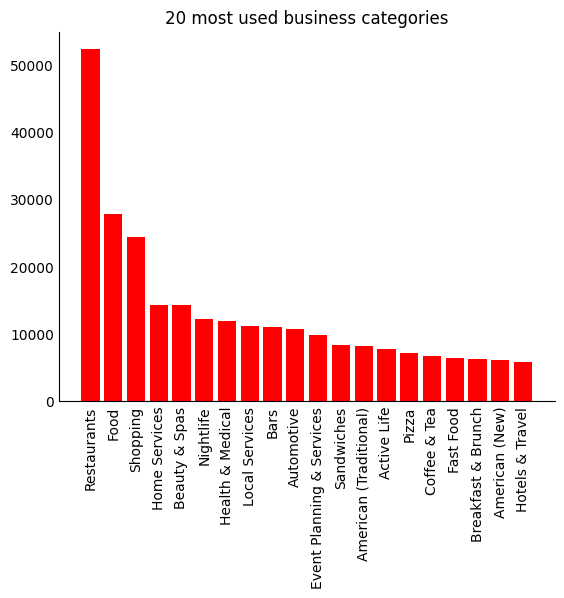

In [24]:
x = [i[0] for i in top_20_categories]
y = [i[1] for i in top_20_categories]

plt.bar(x, y, color='r')
plt.title('20 most used business categories')
plt.xticks(rotation=90)
plt.gca().spines[['right', 'top']].set_visible(False)
plt.tick_params(axis='both', length=0.0)
plt.show();

### Restaurants

In [25]:
# 'Restaurants' is the biggest group. Let's focus on them for further analysis. We need many samples as possible for our machine learning model.

def get_restaurants(row):
    if 'Restaurants' in row:
        return True

In [26]:
businesses.dropna(subset='categories', inplace=True)
restaurants = businesses[businesses['categories'].apply(get_restaurants) == True].copy()

In [27]:
restaurants.reset_index(drop=True, inplace=True)

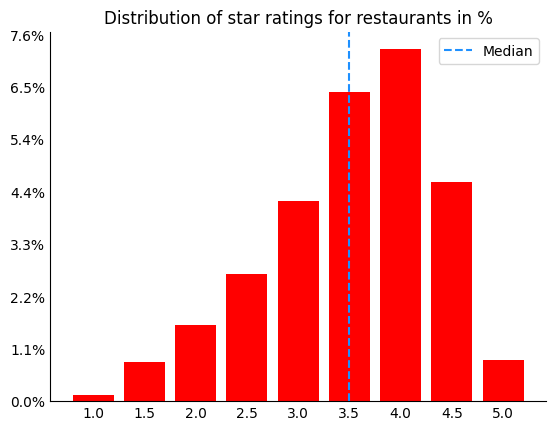

In [136]:
# What is the distrbution of star ratings? What is the median?

from matplotlib.ticker import PercentFormatter

x = restaurants[['business_id', 'stars']].groupby(by='stars').count().index
y = np.reshape(restaurants[['business_id', 'stars']].groupby(by='stars').count().values, (-1))

plt.bar(x, y, color='r', width=0.4)
plt.axvline(restaurants['stars'].median(), color='dodgerblue', linestyle='--', label='Median')
plt.title('Distribution of star ratings for restaurants in %')
plt.gca().spines[['right', 'top']].set_visible(False)
plt.gca().yaxis.set_major_formatter(PercentFormatter(restaurants['stars'].values.sum()))
plt.xticks(np.linspace(1, 5, 9))
plt.gca().spines[['right', 'top']].set_visible(False)
plt.tick_params(axis='both', length=0.0)
plt.legend()
plt.show();


### Prediction of star ratings

There are still several rows with missing values, which can't be handled by Scitkit-learn's models. We can drop all of those rows first.

In [153]:
attributes = restaurants[
    [
        'stars',
        'accepts_credit_cards',
        'bike_parking',
        'price_range',
        'take_out',
        'delivery',
        'caters',
        'wi_fi',
        'outdoor_seating',
        'has_tv',
        'reservations',
        'alcohol',
        'good_for_kids',
        'parking',
        'attire',
        'table_service',
        'good_for_groups',
        'noise_level'
    ]
]

In [154]:
# In addition, columns with multiple features like 'price_range' contain 'None' values that can't be interpreted in a senseful way.
# Also, the 'None's are string objects which need to be converted to NaN values first if we want to drop.

cols = ['price_range', 'attire', 'wi_fi', 'noise_level', 'alcohol']  # Columns with multiple features

for label in cols:
    attributes.loc[attributes[label] == 'None', label] = np.nan

attributes = attributes[attributes[attributes.columns[1:]].isna().any(axis=1) == False]  # Drops all rows that contain any NaN values.

In [155]:
# Columns with binary features also contain 'None' and 'none' values. In this case we can interprete them as False and replace them with False.

attributes = attributes.replace(['none', 'None'], ['False', 'False'])

In [156]:
# Relative frequencies

for label in attributes.iloc[:, 1:]:
    display(attributes[label].value_counts(normalize=True))

accepts_credit_cards
True     0.978188
False    0.021812
Name: proportion, dtype: float64

bike_parking
True     0.778859
False    0.221141
Name: proportion, dtype: float64

price_range
2    0.652349
1    0.304866
3    0.039346
4    0.003440
Name: proportion, dtype: float64

take_out
True     0.949916
False    0.050084
Name: proportion, dtype: float64

delivery
True     0.597064
False    0.402936
Name: proportion, dtype: float64

caters
True     0.62693
False    0.37307
Name: proportion, dtype: float64

wi_fi
free    0.590772
no      0.404362
paid    0.004866
Name: proportion, dtype: float64

outdoor_seating
True     0.547483
False    0.452517
Name: proportion, dtype: float64

has_tv
True     0.745386
False    0.254614
Name: proportion, dtype: float64

reservations
False    0.596477
True     0.403523
Name: proportion, dtype: float64

alcohol
False            0.418037
full_bar         0.405369
beer_and_wine    0.176594
Name: proportion, dtype: float64

good_for_kids
True     0.859899
False    0.140101
Name: proportion, dtype: float64

parking
True     0.881292
False    0.118708
Name: proportion, dtype: float64

attire
casual    0.978440
dressy    0.020805
formal    0.000755
Name: proportion, dtype: float64

table_service
True     0.677768
False    0.322232
Name: proportion, dtype: float64

good_for_groups
True     0.909228
False    0.090772
Name: proportion, dtype: float64

noise_level
average      0.775252
quiet        0.150671
loud         0.059648
very_loud    0.014430
Name: proportion, dtype: float64

In [184]:
for label in attributes.iloc[:, 1:]:
    display(pd.crosstab(attributes['stars'], attributes[label], margins=True))


accepts_credit_cards,False,True,All
stars,,,
1.0,0,8,8
1.5,0,82,82
2.0,2,260,262
2.5,4,641,645
3.0,17,1358,1375
3.5,43,2860,2903
4.0,117,4138,4255
4.5,70,2180,2250
5.0,7,133,140


bike_parking,False,True,All
stars,,,
1.0,3,5,8
1.5,26,56,82
2.0,105,157,262
2.5,202,443,645
3.0,363,1012,1375
3.5,653,2250,2903
4.0,821,3434,4255
4.5,433,1817,2250
5.0,30,110,140


price_range,1,2,3,4,All
stars,,,,,
1.0,6,1,1,0,8
1.5,61,19,1,1,82
2.0,141,120,1,0,262
2.5,219,420,5,1,645
3.0,398,954,21,2,1375
3.5,788,1994,117,4,2903
4.0,1109,2918,216,12,4255
4.5,822,1302,105,21,2250
5.0,90,48,2,0,140


take_out,False,True,All
stars,,,
1.0,2,6,8
1.5,5,77,82
2.0,8,254,262
2.5,22,623,645
3.0,36,1339,1375
3.5,102,2801,2903
4.0,260,3995,4255
4.5,152,2098,2250
5.0,10,130,140


delivery,False,True,All
stars,,,
1.0,2,6,8
1.5,15,67,82
2.0,60,202,262
2.5,190,455,645
3.0,506,869,1375
3.5,1157,1746,2903
4.0,1767,2488,4255
4.5,1031,1219,2250
5.0,75,65,140


caters,False,True,All
stars,,,
1.0,5,3,8
1.5,70,12,82
2.0,182,80,262
2.5,337,308,645
3.0,499,876,1375
3.5,1019,1884,2903
4.0,1577,2678,4255
4.5,730,1520,2250
5.0,28,112,140


wi_fi,free,no,paid,All
stars,,,,
1.0,4,3,1,8
1.5,47,34,1,82
2.0,137,122,3,262
2.5,371,269,5,645
3.0,823,542,10,1375
3.5,1749,1144,10,2903
4.0,2527,1709,19,4255
4.5,1312,931,7,2250
5.0,72,66,2,140


outdoor_seating,False,True,All
stars,,,
1.0,6,2,8
1.5,53,29,82
2.0,153,109,262
2.5,350,295,645
3.0,636,739,1375
3.5,1226,1677,2903
4.0,1873,2382,4255
4.5,1026,1224,2250
5.0,71,69,140


has_tv,False,True,All
stars,,,
1.0,3,5,8
1.5,8,74,82
2.0,26,236,262
2.5,85,560,645
3.0,198,1177,1375
3.5,541,2362,2903
4.0,1170,3085,4255
4.5,925,1325,2250
5.0,79,61,140


reservations,False,True,All
stars,,,
1.0,7,1,8
1.5,76,6,82
2.0,230,32,262
2.5,493,152,645
3.0,829,546,1375
3.5,1613,1290,2903
4.0,2295,1960,4255
4.5,1457,793,2250
5.0,110,30,140


alcohol,False,beer_and_wine,full_bar,All
stars,,,,
1.0,7,0,1,8
1.5,71,0,11,82
2.0,175,10,77,262
2.5,306,41,298,645
3.0,532,151,692,1375
3.5,1009,422,1472,2903
4.0,1598,912,1745,4255
4.5,1169,548,533,2250
5.0,116,21,3,140


good_for_kids,False,True,All
stars,,,
1.0,3,5,8
1.5,10,72,82
2.0,14,248,262
2.5,49,596,645
3.0,136,1239,1375
3.5,406,2497,2903
4.0,737,3518,4255
4.5,307,1943,2250
5.0,8,132,140


parking,False,True,All
stars,,,
1.0,6,2,8
1.5,37,45,82
2.0,106,156,262
2.5,139,506,645
3.0,223,1152,1375
3.5,297,2606,2903
4.0,366,3889,4255
4.5,212,2038,2250
5.0,29,111,140


attire,casual,dressy,formal,All
stars,,,,
1.0,8,0,0,8
1.5,81,1,0,82
2.0,260,1,1,262
2.5,640,4,1,645
3.0,1364,11,0,1375
3.5,2848,52,3,2903
4.0,4133,118,4,4255
4.5,2189,61,0,2250
5.0,140,0,0,140


table_service,False,True,All
stars,,,
1.0,8,0,8
1.5,62,20,82
2.0,157,105,262
2.5,280,365,645
3.0,390,985,1375
3.5,758,2145,2903
4.0,1165,3090,4255
4.5,934,1316,2250
5.0,87,53,140


good_for_groups,False,True,All
stars,,,
1.0,5,3,8
1.5,20,62,82
2.0,30,232,262
2.5,55,590,645
3.0,96,1279,1375
3.5,166,2737,2903
4.0,357,3898,4255
4.5,322,1928,2250
5.0,31,109,140


noise_level,average,loud,quiet,very_loud,All
stars,,,,,
1.0,4,3,1,0,8
1.5,54,15,8,5,82
2.0,184,27,28,23,262
2.5,444,87,84,30,645
3.0,1051,123,160,41,1375
3.5,2303,200,364,36,2903
4.0,3450,174,605,26,4255
4.5,1673,79,487,11,2250
5.0,78,3,59,0,140


In [91]:
# Ordinal classification
# Multiple ordinal regression

In [193]:
star_cat = pd.CategoricalDtype(categories=np.linspace(1, 5, 9), ordered=True)
attributes['stars'] = attributes['stars'].astype(star_cat)

In [194]:
from sklearn.preprocessing import OrdinalEncoder

In [195]:
cols_bool = [
       'accepts_credit_cards',
       'bike_parking',
       'price_range',
       'take_out',
       'delivery',
       'caters',
       'wi_fi',
       'outdoor_seating',
       'has_tv',
       'reservations',
       'alcohol',
       'good_for_kids',
       'parking',
       'attire',
       'table_service',
       'good_for_groups',
       'noise_level'
]

for col in cols_bool:
    enc = OrdinalEncoder()
    enc.fit(np.reshape(attributes[col], (-1, 1)))
    enc.categories_
    attributes[col] = enc.transform(np.reshape(attributes[col], (-1, 1)))

In [187]:
import numpy as np
from sklearn.model_selection import train_test_split

In [196]:
train, test = train_test_split(attributes, test_size=0.2, shuffle=True)

In [189]:
from statsmodels.miscmodels.ordinal_model import OrderedModel
# https://www.youtube.com/watch?v=pQWQSCSrBk4
# https://stats.oarc.ucla.edu/stata/dae/ordered-logistic-regression/
# Multinomial model?

In [197]:
mod_log = OrderedModel(train.iloc[:, 0], train.iloc[:, 1:], distr='logit')
res_log = mod_log.fit(method='bfgs', disp=True)
res_log.summary()

# p value (wald's test): variable is significantly associated with target variable

Optimization terminated successfully.
         Current function value: 1.545568
         Iterations: 103
         Function evaluations: 104
         Gradient evaluations: 104


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                  stars   Log-Likelihood:                -14739.
Model:                   OrderedModel   AIC:                         2.953e+04
Method:            Maximum Likelihood   BIC:                         2.971e+04
Date:                Fri, 26 Jan 2024                                         
Time:                        16:42:44                                         
No. Observations:                9536                                         
Df Residuals:                    9511                                         
Df Model:                          17                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
accepts_credit_cards    -0.5418      0.131     -4.130      0.000      -0.799      -0.285
bike_parking             0.4047      0.046      8.745      0.000       0.314       0.495
price_range              0.0711      0.046      1.554      0.120      -0.019       0.161
take_out                -0.3984      0.089     -4.502      0.000      -0.572      -0.225
delivery                -0.3822      0.040     -9.599      0.000      -0.460      -0.304
caters                   0.3789      0.041      9.290      0.000       0.299       0.459
wi_fi                   -0.0523      0.039     -1.343      0.179      -0.129       0.024
outdoor_seating          0.0356      0.040      0.886      0.376      -0.043       0.114
has_tv                  -0.7351      0.047    -15.806      0.000      -0.826      -0.644
reservations             0.1576      0.045      3.497      0.000       0.069       0.246
alcohol                 -0.3106      0.028    -11.044      0.000      -0.366      -0.255
good_for_kids           -0.2669      0.059     -4.535      0.000      -0.382      -0.152
parking                  0.7532      0.063     12.023      0.000       0.630       0.876
attire                   0.1939      0.129      1.501      0.133      -0.059       0.447
table_service            0.0992      0.052      1.917      0.055      -0.002       0.201
good_for_groups         -0.3566      0.071     -4.991      0.000      -0.497      -0.217
noise_level             -0.0044      0.025     -0.174      0.862      -0.053       0.045
1.0/1.5                 -8.4289      0.397    -21.243      0.000      -9.207      -7.651
1.5/2.0                  0.7723      0.154      5.024      0.000       0.471       1.074
2.0/2.5                  0.3759      0.073      5.156      0.000       0.233       0.519
2.5/3.0                  0.1121      0.045      2.506      0.012       0.024       0.200
3.0/3.5                  0.0433      0.029      1.471      0.141      -0.014       0.101
3.5/4.0                  0.2261      0.019     11.897      0.000       0.189       0.263
4.0/4.5                  0.5658      0.015     36.814      0.000       0.536       0.596
4.5/5.0                  1.1614      0.030     38.188      0.000       1.102       1.221
========================================================================================
"""

In [209]:
res_log.predict(which='prob').shape

(9536, 9)

In [126]:
predicted = res_log.model.predict(res_log.params, exog=test.iloc[:, 1:])

array([[0.00052378, 0.0057924 , 0.01845528, ..., 0.38060276, 0.17187072,
        0.00986019],
       [0.00054122, 0.00598397, 0.01905027, ..., 0.37734454, 0.16736378,
        0.00954538],
       [0.00074085, 0.0081716 , 0.02577653, ..., 0.34025703, 0.12869351,
        0.00698977],
       ...,
       [0.00105938, 0.01164032, 0.03618965, ..., 0.28945182, 0.09399723,
        0.00489687],
       [0.00070627, 0.00779341, 0.0246226 , ..., 0.34649177, 0.13406203,
        0.00732977],
       [0.00100706, 0.01107239, 0.03450555, ..., 0.29694996, 0.0983548 ,
        0.00515023]])

In [128]:
pred_choice = predicted.argmax(1)
print('Fraction of correct choice predictions')
print((np.asarray(train.iloc[:, 0].values.codes) == pred_choice).mean())


Fraction of correct choice predictions


ValueError: operands could not be broadcast together with shapes (9536,) (2384,) 

In [129]:
from sklearn.metrics import mean_squared_error

In [130]:
y_pred = res_log.predict(test.iloc[:, 1:])

In [131]:
y_pred_ord = np.argmax(y_pred.values, axis=1) + 1

In [133]:
mse = mean_squared_error(test.iloc[:, 0].values, y_pred_ord)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 10.64261744966443


### What are the average opening hours of a restaurant? How many days is it open per week?

### Review count

In [ ]:
cols = ['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday']

In [ ]:
restaurants[cols] = restaurants[cols].apply(lambda x: x.str.split('-'))

In [ ]:
def padding_time(x):
    if x is not np.nan:
        return [x[0] + ':00', x[1] + ':00']
    else:
        return np.nan

In [ ]:
restaurants[cols] = restaurants[cols].map(padding_time)

In [ ]:
def convert_time(x):
    if x is not np.nan:
        return [pd.to_timedelta(x[0]), pd.to_timedelta(x[1])]
    else:
        return pd.to_timedelta('nat')

In [ ]:
restaurants[cols] = restaurants[cols].map(convert_time)

In [ ]:
def get_hours(x):
    if x is pd.NaT:
        return pd.to_timedelta('nat')
    elif x[1] > x[0]:
        return x[1] - x[0]
    else:
        return x[1] - x[0] + pd.to_timedelta('24:00:00')

In [ ]:
restaurants[cols] = restaurants[cols].map(get_hours)

### knn

In [25]:
restaurants['days_open'] = restaurants[cols].count(axis=1)

In [26]:
restaurants['daily_avg_hours'] = restaurants[cols].sum(axis=1) / restaurants['days_open']

In [27]:
restaurants[['daily_avg_hours', 'days_open']]

,daily_avg_hours,days_open
0,0 days 13:25:42.857142857,7
1,0 days 16:17:08.571428571,7
2,NaT,0
3,0 days 14:17:08.571428571,7
4,0 days 03:17:08.571428571,7
...,...,...
52263,1 days 00:00:00,7
52264,0 days 23:00:00,7
52265,0 days 12:20:00,6
52266,1 days 00:00:00,7


In [223]:
from sklearn.neighbors import KNeighborsClassifier

In [228]:
neigh = KNeighborsClassifier(n_neighbors=15)
neigh.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=15)

In [229]:
y_pred = neigh.predict(X_test)

In [230]:
print(classification_report(y_test, y_pred, zero_division=np.nan))

              precision    recall  f1-score   support

           0        nan      0.00       nan         3
           1        nan      0.00       nan        16
           2       0.40      0.12      0.19        65
           3       0.22      0.16      0.19       122
           4       0.14      0.06      0.09       275
           5       0.28      0.26      0.27       572
           6       0.38      0.63      0.48       847
           7       0.34      0.16      0.22       463
           8        nan      0.00       nan        21

    accuracy                           0.34      2384
   macro avg       0.29      0.16      0.24      2384
weighted avg       0.31      0.34      0.31      2384



In [233]:
from sklearn.ensemble import RandomForestRegressor

In [234]:
regr = RandomForestRegressor(max_depth=2, random_state=0)
regr.fit(X_train, y_train)

RandomForestRegressor(max_depth=2, random_state=0)

In [235]:
y_pred = neigh.predict(X_test)

In [236]:
print(classification_report(y_test, y_pred, zero_division=np.nan))

              precision    recall  f1-score   support

           0        nan      0.00       nan         3
           1        nan      0.00       nan        16
           2       0.40      0.12      0.19        65
           3       0.22      0.16      0.19       122
           4       0.14      0.06      0.09       275
           5       0.28      0.26      0.27       572
           6       0.38      0.63      0.48       847
           7       0.34      0.16      0.22       463
           8        nan      0.00       nan        21

    accuracy                           0.34      2384
   macro avg       0.29      0.16      0.24      2384
weighted avg       0.31      0.34      0.31      2384



In [238]:
from sklearn.ensemble import GradientBoostingClassifier

In [239]:
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0).fit(X_train, y_train)
clf.score(X_test, y_test)

0.32550335570469796

In [240]:
from sklearn.svm import SVC

In [246]:
clf = SVC(gamma='auto', kernel='sigmoid')
clf.fit(X_train, y_train)

SVC(gamma='auto', kernel='sigmoid')

In [247]:
y_pred = clf.predict(X_test)

In [248]:
print(classification_report(y_test, y_pred, zero_division=np.nan))

              precision    recall  f1-score   support

           0        nan      0.00       nan         3
           1        nan      0.00       nan        16
           2        nan      0.00       nan        65
           3       0.08      0.02      0.03       122
           4       0.04      0.00      0.01       275
           5       0.26      0.11      0.16       572
           6       0.37      0.59      0.46       847
           7       0.17      0.27      0.21       463
           8        nan      0.00       nan        21

    accuracy                           0.29      2384
   macro avg       0.18      0.11      0.17      2384
weighted avg       0.25      0.29      0.25      2384



### We have created a table with all restaurants in Pennsylvania and saved it in a .csv for later analysis

### Now we load the table with all reviews and create a .csv which only contains reviews from restaurants in Pennsylvania

In [ ]:
businesses_ids = restaurants['business_id'].to_list()

column_names = ['review_id', 'user_id', 'business_id', 'stars', 'useful', 'funny', 'cool', 'text', 'date']

chunks = pd.read_json('yelp_dataset/yelp_academic_dataset_review.json', lines=True, chunksize=100000)

with open('tables/reviews_pennsylvania.csv', 'w') as f:
    header = ','.join(column_names)
    f.write(header + '\n')

    for chunk in chunks:
        reviews = pd.DataFrame(chunk)
        
        reviews[reviews['business_id'].isin(businesses_ids)].to_csv(f, mode='a', header=False, index=False)

### Analysis starts here

In [ ]:
restaurants = get_file('tables/restaurants_pennsylvania.csv')

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, figsize=(5, 5))

# fig.suptitle('Customer ratings', fontsize=16)

sns.barplot(
    ax = ax,
    x=restaurants['stars'].value_counts().sort_index().index,
    y=restaurants['stars'].value_counts().sort_index().values*100/restaurants['stars'].value_counts().sort_index().values.sum(),
    color='#FF1A1A'
)
ax.set(xlabel='Stars', ylabel='No. of businesses in %')
ax.set_title('Star ratings');

In [ ]:
restaurants[[
    'stars',
    'accepts_credit_cards',
    'bike_parking',
    'price_range',
    'take_out',
    'delivery',
    'caters',
    'wi_fi',
    'outdoor_seating',
    'has_tv',
    'reservations',
    'alcohol',
    'good_for_kids',
    'attire',
    'table_service',
    'good_for_groups',
    'noise_level',
    'parking_available'
]].corr(method='spearman')

In [ ]:
reviews = get_file('tables/reviews_pennsylvania.csv')

In [ ]:
import spacy
from spacytextblob.spacytextblob import SpacyTextBlob

nlp = spacy.load('en_core_web_md')
nlp.add_pipe('spacytextblob')

def check_polarity(text):
    doc = nlp(text)
    return doc._.blob.polarity

reviews['polarity'] = reviews['text'][:10000].apply(lambda x: check_polarity(x))

In [ ]:
with open('tables/reviews_polarity.csv', 'w') as f:
    reviews[:10000].to_csv(f, header=True, index=False)

In [ ]:
reviews = get_file('tables/reviews_polarity.csv')

In [ ]:
negative_reviews = reviews[reviews['polarity'] < 0]

### Analys negative reviews

#### We want to find statements about food

In [ ]:
# Training the entity rule to recognize food

food = pd.read_csv('food_labels/food.csv')

In [ ]:
food_labels = food[food['description'].str.contains('[a-zA-Z]') == True]['description']

In [ ]:
food_labels = food_labels[food_labels.str.split().apply(len) <= 2].drop_duplicates()

In [ ]:
food_labels = food_labels.str.lower()

In [ ]:
food_labels = food_labels[food_labels.str.contains('.*,.*,.*', regex=True) == False]

In [ ]:
# Fix: Foods are comma seperated and order is reversed: 'muffins, blueberry' become 'blueberry muffins'

food_labels[food_labels.str.contains(', ') == True] = (
    food_labels[food_labels.str.contains(', ') == True].str.split(', ', expand=True)[1] +
    ' ' +
    food_labels[food_labels.str.contains(', ') == True].str.split(', ', expand=True)[0]
)

food_labels[food_labels.str.contains(',') == True] = (
    food_labels[food_labels.str.contains(',') == True].str.split(',', expand=True)[1] +
    ' ' +
    food_labels[food_labels.str.contains(',') == True].str.split(',', expand=True)[0]
)

In [ ]:
# If label has no plural, create singular form. If label has no singular, create plural 

import spacy
import lemminflect

nlp = spacy.load('en_core_web_lg')

inflected_labels = []

for label in food_labels:
    
    doc = nlp(label)

    if len(doc) == 1:
        if doc[0].tag_ == 'NNS':
            inflected_labels.append(doc[0]._.inflect('NN'))
        else:
            inflected_labels.append(doc[0]._.inflect('NNS'))

    if len(doc) == 2:
        if doc[1].tag_ == 'NNS':
            inflected_labels.append(doc[0].text + ' ' + doc[1]._.inflect('NN'))
        else:
            inflected_labels.append(doc[0].text + ' ' + doc[1]._.inflect('NNS'))

In [ ]:
food_labels_inflected = pd.Series(inflected_labels)

In [ ]:
food_labels = pd.concat([food_labels, food_labels_inflected])

In [ ]:
food_labels.drop_duplicates(inplace=True)

In [ ]:
food_labels[food_labels.str.contains('bar', regex=True)]

In [ ]:
# Add food labels to entity ruler

food_labels = food_labels  # Remove 'bar' from foods_labels, add 'product'

patterns = []

nlp = spacy.load('en_core_web_lg')

ruler = nlp.add_pipe('entity_ruler', before='ner')

for label in food_labels:
    patterns.append({'label': 'FOOD', 'pattern': label})

ruler.add_patterns(patterns)

In [ ]:
len(patterns)

In [ ]:
ruler.to_disk('food_labels/food_patterns.jsonl')

In [ ]:
nlp = spacy.load('en_core_web_lg')

ruler = nlp.add_pipe("entity_ruler", before='ner')

ruler.from_disk('food_labels/food_patterns.jsonl')